<a href="https://colab.research.google.com/github/aidaaminian/snn-self-driving/blob/snn-autoencoder/bproj_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install and Import

In [1]:
!gdown --id 1BuZNKbH3qWgedopUGwW9Gfue7oCbBTDm

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1BuZNKbH3qWgedopUGwW9Gfue7oCbBTDm
To: /content/traffic-sign-yolo.zip
100% 261M/261M [00:05<00:00, 45.7MB/s]


In [2]:
!unzip "/content/traffic-sign-yolo.zip" -d "/content/"

Archive:  /content/traffic-sign-yolo.zip
   creating: /content/traffic-sign-yolo/
  inflating: /content/traffic-sign-yolo/00000.jpg  
  inflating: /content/traffic-sign-yolo/00000.txt  
  inflating: /content/traffic-sign-yolo/00001.jpg  
  inflating: /content/traffic-sign-yolo/00001.txt  
  inflating: /content/traffic-sign-yolo/00002.jpg  
  inflating: /content/traffic-sign-yolo/00002.txt  
  inflating: /content/traffic-sign-yolo/00003.jpg  
  inflating: /content/traffic-sign-yolo/00003.txt  
  inflating: /content/traffic-sign-yolo/00004.jpg  
  inflating: /content/traffic-sign-yolo/00004.txt  
  inflating: /content/traffic-sign-yolo/00005.jpg  
  inflating: /content/traffic-sign-yolo/00005.txt  
  inflating: /content/traffic-sign-yolo/00006.jpg  
  inflating: /content/traffic-sign-yolo/00006.txt  
  inflating: /content/traffic-sign-yolo/00007.jpg  
  inflating: /content/traffic-sign-yolo/00007.txt  
  inflating: /content/traffic-sign-yolo/00008.jpg  
  inflating: /content/traffic-sign

In [3]:
!pip install nengo
!pip install nengo-dl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.3/535.3 kB 12.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.2/286.2 kB 9.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nengo-dl: filename=nengo_dl-3.6.0-py3-none-any.whl size=204190 sha256=2bad0387dcd57b5264ec5ab4d38a33a2c47aeeb3a61026b9a5c470361b6fc5ca
  Stored in directory: /root/.cache/pip/wheels/99/98/1a/c238f79c953dec26b4345dc4aa1a9b7b0b250bac1018985465
Successfully built nengo-dl


In [4]:
%matplotlib inline
import nengo
import nengo_dl
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlretrieve

### Load Data

In [5]:
IMG_HEIGHT = 240
IMG_WIDTH = 240
MINIBATCH_SIZE = 32
N_STEPS = 10

In [6]:
dir_path = '/content/'

In [7]:
import cv2
import glob
image_list = []
for filename in glob.glob(dir_path + 'traffic-sign-yolo/*.jpg'):
    image = cv2.imread (filename)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = cv2.resize(image,(240,240))
    image_list.append (image)

### Data Preprocessing

In [8]:
np.array(image_list).shape

(741, 240, 240, 3)

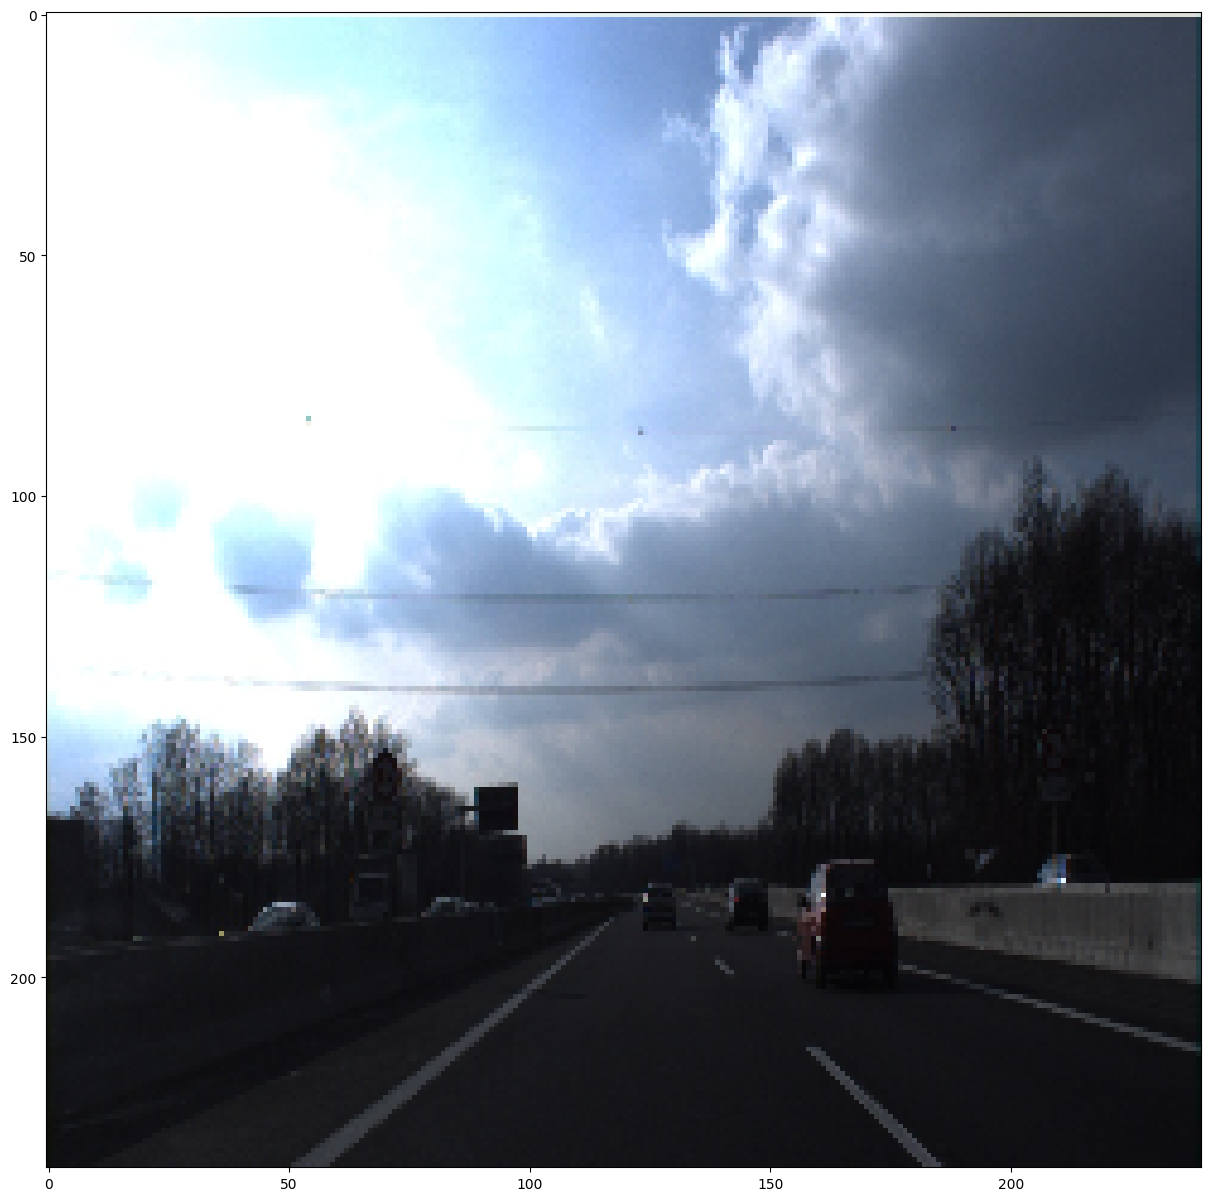

In [9]:
plt.figure(figsize=(15,15))
plt.imshow(image_list[8])
plt.show()

In [10]:
train_data = np.reshape(image_list, (len(image_list), -1))

In [11]:
train_data.shape

(741, 172800)

### Autoencoder Network

In [12]:
with nengo.Network(seed = 0) as auto_net:
    auto_net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([200])
    auto_net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    auto_net.config[nengo.Connection].synapse = None

    n_type = nengo.SpikingRectifiedLinear() 
    n_in = IMG_HEIGHT*IMG_WIDTH*3
    dim_hidden = 512

    input_node = nengo.Node(np.zeros(n_in))

    layer1 = nengo.Ensemble(dim_hidden, 1, neuron_type = n_type)
    nengo.Connection(input_node, layer1.neurons, transform=nengo_dl.dists.Glorot())

    layer2 = nengo.Ensemble(dim_hidden, 1, neuron_type = n_type)
    nengo.Connection(layer1.neurons, layer2.neurons, transform=nengo_dl.dists.Glorot())

    outp = nengo.Ensemble(n_in, 1, neuron_type=n_type)
    nengo.Connection(layer2.neurons, outp.neurons, transform=nengo_dl.dists.Glorot())

    p_c = nengo.Probe(outp.neurons)
    p_c_filt = nengo.Probe(outp.neurons, synapse=0.01, label="out_p_filt")

In [13]:
with nengo_dl.Simulator(network=auto_net, minibatch_size=MINIBATCH_SIZE) as sim:
  sim.predict(np.ones((MINIBATCH_SIZE, 1, n_in)));

Build finished in 0:00:04                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:04                                               
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

/usr/local/lib/python3.10/dist-packages/nengo_dl/simulator.py:1003: UserWarning: Running for one timestep, but the network contains synaptic filters (which will introduce at least a one-timestep delay); did you mean to set synapse=None?
  warnings.warn(


1/1 [==============================] - 5s 5s/step


### Train Model

In [14]:
for net_ens in auto_net.all_ensembles:
  net_ens.gain = nengo.dists.Choice([1])
  net_ens.bias = nengo.dists.Choice([0])

In [15]:
for conn in auto_net.all_connections:
  conn.synapse = None 

In [16]:
test_data = train_data

In [17]:
train_data.shape

(741, 172800)

In [18]:
train_data = train_data[:, None, :]

In [19]:
train_data.shape

(741, 1, 172800)

In [20]:
test_data = np.tile(test_data[:, None, :], (1, N_STEPS, 1))

In [21]:
test_data.shape

(741, 10, 172800)

In [22]:
train_data

array([[[219, 231, 232, ...,  36,  67,  73]],

       [[228, 228, 206, ...,  19,  33,  35]],

       [[255, 255, 255, ...,  30,  43,  38]],

       ...,

       [[255, 255, 255, ...,  96, 109, 102]],

       [[255, 255, 255, ...,  33,  50,  39]],

       [[234, 230, 206, ...,  14,  27,  32]]], dtype=uint8)

In [23]:
test_data

array([[[219, 231, 232, ...,  36,  67,  73],
        [219, 231, 232, ...,  36,  67,  73],
        [219, 231, 232, ...,  36,  67,  73],
        ...,
        [219, 231, 232, ...,  36,  67,  73],
        [219, 231, 232, ...,  36,  67,  73],
        [219, 231, 232, ...,  36,  67,  73]],

       [[228, 228, 206, ...,  19,  33,  35],
        [228, 228, 206, ...,  19,  33,  35],
        [228, 228, 206, ...,  19,  33,  35],
        ...,
        [228, 228, 206, ...,  19,  33,  35],
        [228, 228, 206, ...,  19,  33,  35],
        [228, 228, 206, ...,  19,  33,  35]],

       [[255, 255, 255, ...,  30,  43,  38],
        [255, 255, 255, ...,  30,  43,  38],
        [255, 255, 255, ...,  30,  43,  38],
        ...,
        [255, 255, 255, ...,  30,  43,  38],
        [255, 255, 255, ...,  30,  43,  38],
        [255, 255, 255, ...,  30,  43,  38]],

       ...,

       [[255, 255, 255, ...,  96, 109, 102],
        [255, 255, 255, ...,  96, 109, 102],
        [255, 255, 255, ...,  96, 109, 102

In [25]:
with nengo_dl.Simulator(auto_net, minibatch_size=MINIBATCH_SIZE) as sim:
  sim.compile(optimizer = tf.optimizers.Adam(1e-5), 
              loss = {p_c: tf.losses.mse,
                      p_c_filt: None}
             ) 
  sim.fit(train_data, train_data, epochs = 3000)
  sim.freeze_params(auto_net)
  sim.save_params("./my_saved_params3")
  output = sim.predict(test_data[:MINIBATCH_SIZE])

Build finished in 0:00:05                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:01                                               


/usr/local/lib/python3.10/dist-packages/nengo_dl/simulator.py:1892: UserWarning: Number of elements in input data (741) is not evenly divisible by Simulator.minibatch_size (32); input data will be truncated.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nengo_dl/simulator.py:1736: UserWarning: Number of elements (1) in ['ndarray'] does not match number of Probes (2); consider using an explicit input dictionary in this case, so that the assignment of data to objects is unambiguous.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
Epoch 497/3000
23/23 [==============================] - 2s 66ms/step - loss: 1306.1670 - probe_loss: 1306.1670
Epoch 498/3000
23/23 [==============================] - 2s 66ms/step - loss: 1303.8606 - probe_loss: 1303.8606
Epoch 499/3000
23/23 [==============================] - 1s 64ms/step - loss: 1303.2845 - probe_loss: 1303.2845
Epoch 500/3000
23/23 [==============================] - 1s 64ms/step - loss: 1302.0822 - probe_loss: 1302.0822
Epoch 501/3000
23/23 [==============================] - 1s 62ms/step - loss: 1300.4950 - probe_loss: 1300.4950
Epoch 502/3000
23/23 [==============================] - 1s 64ms/step - loss: 1299.3582 - probe_loss: 1299.3582
Epoch 503/3000
23/23 [==============================] - 1s 64ms/step - loss: 1297.1421 - probe_loss: 1297.1421
Epoch 504/3000
23/23 [==============================] - 1s 64ms/step - loss: 1295.9426 - probe_loss: 1295.9426
Epoch 505/3000
23/23 [==============================] - 2s 67

In [26]:
# with nengo_dl.Simulator(auto_net, minibatch_size=MINIBATCH_SIZE) as sim2:
#     sim2.load_params("./my_saved_params")

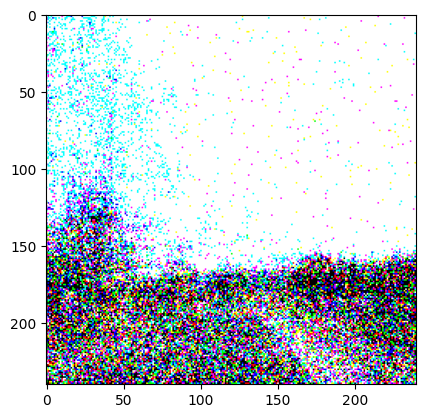

In [35]:
plt.figure()
plt.imshow(output[p_c_filt][0,7].reshape((240, 240, 3)))

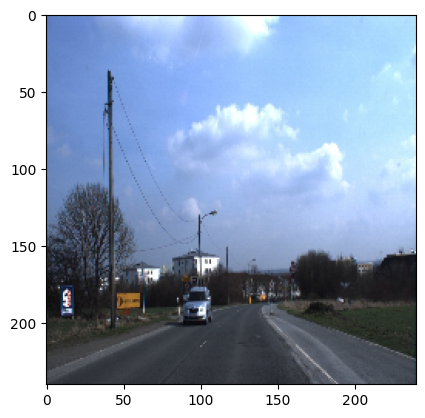

In [36]:
plt.imshow(test_data[0, 7].reshape(240, 240, 3))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')